# An Introduction to JAX

#### Prepared for the CBC QuantEcon Workshop (September 2022)

#### John Stachurski

JAX is a language and compiler for fast linear algebra operations and automatic differentiation.

Loosely speaking, JAX is like NumPy with the addition of

* automatic differentiation
* automated GPU/TPU support
* a just-in-time compiler

JAX is often used for machine learning and AI, since it can scale to big data operations on GPUs and automatically differentiate loss functions for gradient decent.

Here is a short history of JAX:

* 2015: Google open-sources part of its AI infrastructure called TensorFlow.
* 2016: The popularity of TensorFlow grows rapidly.
* 2017: Facebook open-sources PyTorch beta, an alternative AI framework (developer-friendly, more Pythonic)
* 2018: Facebook launches a full production-ready version of PyTorch.
* 2019: PyTorch explodes in popularity (adopted by Uber, Airbnb, Tesla, etc.)
* 2020: Google launches JAX as an open-source framework.
* 2021: Google starts to shift away from TPUs to Nvidia GPUs, JAX development accelerates.
* 2022: JAX popularity begins to take off.

## Installation

JAX can be installed with or without GPU support.

* Follow [the install guide](https://github.com/google/jax)

Note that JAX is pre-installed with GPU support on [Google Colab](https://colab.research.google.com/).

(Colab Pro offers better GPUs.)

## JAX as a NumPy Replacement

One way to use JAX is as a direct NumPy replacement.  Let's look at the similarities and differences.

### Similarities

The following import is standard, replacing `import numpy as np`:

In [1]:
import jax
import jax.numpy as jnp

Now we can use `jnp` in place of `np` for the usual array operations:

In [2]:
a = jnp.asarray((1.0, 3.2, -1.5))

In [3]:
print(a)

[ 1.   3.2 -1.5]


In [4]:
print(jnp.sum(a))

2.6999998


In [5]:
print(jnp.mean(a))

0.9


In [6]:
print(jnp.dot(a, a))

13.490001


However, the array object `a` is not a NumPy array:

In [10]:
a

DeviceArray([ 1. ,  3.2, -1.5], dtype=float32)

In [11]:
type(a)

jaxlib.xla_extension.DeviceArray

Likewise, scalar deductions on arrays are of type `DeviceArray`:

In [12]:
type(jnp.sum(a))

jaxlib.xla_extension.DeviceArray

In [13]:
jnp.sum(a)

DeviceArray(2.6999998, dtype=float32)

The term `Device` refers to GPUs, although JAX falls back to the CPU if no GPU is connected.

(In the terminology of GPUs, the "host" is the machine that launches GPU operations, while the "device" is the GPU itself.)

If JAX is installed with GPU support, then JAX uses 32 bit floats by default.  This is standard for GPU computing.

Operations on higher dimensional arrays is also similar to NumPy:

In [14]:
A = jnp.ones((2, 2))
B = jnp.identity(2)
A @ B

DeviceArray([[1., 1.],
             [1., 1.]], dtype=float32)

In [15]:
from jax.numpy import linalg

In [16]:
linalg.solve(B, A)

DeviceArray([[1., 1.],
             [1., 1.]], dtype=float32)

In [17]:
linalg.eigh(B)  # Computes eigenvalues and eigenvectors

(DeviceArray([0.99999994, 0.99999994], dtype=float32),
 DeviceArray([[1., 0.],
              [0., 1.]], dtype=float32))

### Differences

As a NumPy replacement, the biggest difference is that arrays are treated as **immutable**.  For example, with NumPy we can write 

In [18]:
import numpy as np
a = np.linspace(0, 1, 3)
a

array([0. , 0.5, 1. ])

In [19]:
a[0] = 1
a

array([1. , 0.5, 1. ])

In JAX this fails:

In [20]:
a = jnp.linspace(0, 1, 3)
a

DeviceArray([0. , 0.5, 1. ], dtype=float32)

In [21]:
a[0] = 1

TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In line with immutability, JAX does not support inplace operations:

In [22]:
a = np.array((2, 1))
a.sort()
a

array([1, 2])

In [23]:
a = jnp.array((2, 1))
a.sort()
a

DeviceArray([2, 1], dtype=int32)

The designers of JAX chose to make arrays immutable because JAX uses a functional programming style.  More on this below.  

Note that, while mutation is discouraged, it is in fact possible with `at`, as in

In [24]:
a = jnp.linspace(0, 1, 3)
id(a)

139742331303856

In [25]:
a

DeviceArray([0. , 0.5, 1. ], dtype=float32)

In [26]:
a.at[0].set(1)

DeviceArray([1. , 0.5, 1. ], dtype=float32)

We can check that the array is mutated by verifying its identity is unchanged:

In [27]:
id(a)

139742331303856

## Random Numbers



Random numbers are also a bit different in JAX than in NumPy.  Typically, in JAX, the state of the random number generator needs to be controlled explicitly.

In [28]:
import jax.random as random

First we produce a key, which seeds the random number generator.

In [29]:
key = random.PRNGKey(1)

In [30]:
type(key)

jaxlib.xla_extension.DeviceArray

In [31]:
print(key)

[0 1]


Now we can use the key to generate some random numbers:

In [32]:
x = random.normal(key, (3, 3))
x

DeviceArray([[ 0.690805  , -0.48744103, -1.155789  ],
             [ 0.12108463,  1.2010182 , -0.5078766 ],
             [ 0.91568655,  1.70968   , -0.36749417]], dtype=float32)

If we use the same key again, we initialize at the same seed, so the random numbers are the same:

In [33]:
random.normal(key, (3, 3))

DeviceArray([[ 0.690805  , -0.48744103, -1.155789  ],
             [ 0.12108463,  1.2010182 , -0.5078766 ],
             [ 0.91568655,  1.70968   , -0.36749417]], dtype=float32)

To produce a (quasi-) independent draw, best practice is to "split" the existing key:

In [34]:
key, subkey = random.split(key)

In [35]:
random.normal(key, (3, 3))

DeviceArray([[-0.64377284,  0.7696183 , -0.29809612],
             [ 0.47858787,  1.3699535 ,  1.2741846 ],
             [-0.4408543 , -0.2564722 ,  1.4826155 ]], dtype=float32)

In [36]:
random.normal(subkey, (3, 3))

DeviceArray([[-0.58221203,  0.5907554 , -0.22852424],
             [ 1.8015778 ,  0.22681691, -0.07008386],
             [ 0.9982648 , -0.1906528 ,  0.22489986]], dtype=float32)

The function below produces `k` (quasi-) independent random `n x n` matrices using this procedure.

In [37]:
def gen_random_matrices(key, n, k):
    matrices = []
    for _ in range(k):
        key, subkey = random.split(key)
        matrices.append(random.uniform(subkey, (n, n)))
    return matrices


In [38]:
matrices = gen_random_matrices(key, 2, 2)
for A in matrices:
    print(A)

[[0.5101472  0.26307964]
 [0.037184   0.5259018 ]]
[[0.22010922 0.736096  ]
 [0.82404494 0.28857923]]


One point to remember is that JAX expects tuples to describe array shapes, even for flat arrays.  Hence, to get a one-dimensional array of normal random draws we use `(len, )` for the shape, as in

In [39]:
random.normal(key, (5, ))

DeviceArray([ 0.9087967 , -0.040249  ,  0.17204419, -1.6576358 ,
              0.353745  ], dtype=float32)

## JIT Compilation

The JAX JIT compiler accelerates logic within functions by fusing linear algebra operations into a single, highly optimized kernel that the host can launch on the GPU / TPU (or CPU if no accelerator is detected).

Consider the following pure Python function.

In [40]:
def f(x):
    return sum((k*x for k in range(1000)))

Let's build an array to call the function on.

In [41]:
n = 50_000_000
x = jnp.ones(n)

How long does the function take to execute?

In [43]:
%time f(x)

CPU times: user 274 ms, sys: 161 ms, total: 435 ms
Wall time: 1.47 s


DeviceArray([499500., 499500., 499500., ..., 499500., 499500., 499500.],            dtype=float32)

This code is run on the GPU because `x` is a DeviceArray.  However each vector `k * x` is instantiated before the final sum is computed.

If we JIT-compile the function with JAX, then the operations are fused and no intermediate arrays are created.

In [44]:
f_jit = jax.jit(f)

Let's run once to compile it:

In [45]:
f_jit(x)

DeviceArray([499500., 499500., 499500., ..., 499500., 499500., 499500.],            dtype=float32)

And now let's time it.

In [52]:
%time f_jit(x).block_until_ready()

CPU times: user 573 µs, sys: 165 µs, total: 738 µs
Wall time: 8.91 ms


DeviceArray([499500., 499500., 499500., ..., 499500., 499500., 499500.],            dtype=float32)

## Functional Programming

From JAX's documentation:

*When walking about the countryside of Italy, the people will not hesitate to tell you that JAX has “una anima di pura programmazione funzionale”.*

JAX functions should be pure:
    
* no dependence on global variables
* no side effects

"A pure function will always return the same result if invoked with the same inputs."

JAX will not usually throw errors when compiling impure functions but execution becomes unpredictable.

In [53]:
a = 1  # global

@jax.jit
def f(x):
    return a + x

In [54]:
x = jnp.ones(2)

In [55]:
f(x)

DeviceArray([2., 2.], dtype=float32)

In the code above, the global value `a=1` is fused into the jitted function.

Even if we change `a`, the output of `f` will not be affected --- as long as the same compiled version is called.

In [56]:
a = 42

In [57]:
f(x)

DeviceArray([2., 2.], dtype=float32)

Changing the dimension of the input triggers a fresh compilation of the function, at which time the change in the value of `a` takes effect:

In [60]:
x = np.ones(3)

In [61]:
f(x)

DeviceArray([43., 43., 43.], dtype=float32)

Moral of the story: write pure functions when using JAX!

## Gradients

JAX can use automatic differentiation to compute gradients.

In [62]:
def f(x):
    return (x**2) / 2

In [63]:
f_prime = jax.grad(f)

In [64]:
f_prime(10.0)

DeviceArray(10., dtype=float32, weak_type=True)

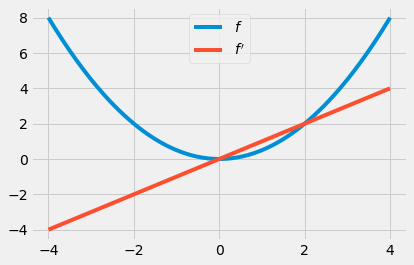

In [65]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots()
x_grid = jnp.linspace(-4, 4, 200)
ax.plot(x_grid, f(x_grid), label="$f$")
ax.plot(x_grid, [f_prime(x) for x in x_grid], label="$f'$")
ax.legend(loc='upper center')
plt.show()